# <font color = 'orange'>**Multilayer Perceptron (MLP)**</font>

A multilayer perceptron is a basic neural neural network where the hidden layers are densely connected vectors i.e., every neuron in one layer is connected to every other neuron in the next layer.<br/>
In this tutorial we are going to construct one such network to classify the MNIST handwritten digit database.
We will build the network progressively, evolving it at every step, to fit our needs.<br/>
The purpose of this tutorial is to convey the process of gaining an intuition about the architecture of a neural network that suits a particular type of deep learning problem.<br/><br/>

**Please Note:** Due to the stochastic nature of our model, your results might differ from previous ones already documented. Please take the accompanying text with a grain of salt.

---------------------

Keras has an API to directly load the MNIST digit dataset neatly split into training and testing sets along with relevant labels.
<font size='5'>``tensorflow.keras.datasets.mnist``<font/>

In [ ]:
import numpy as np
from keras.initializers import RandomNormal
from keras.layers import Activation, Dense, Dropout, Flatten, ReLU
from keras.models import Model
from keras.models import Input
from keras.optimizers import Adam
from keras.utils import to_categorical, plot_model
from tensorflow.keras.datasets import mnist
import matplotlib.pyplot as plt

---------------

## <font color='orange'>**Dataset**<font/>

MNIST (Modified National Institute of Standards and Technology) digits is a collection of handwritten digits ranging from 0 to 9. It has a training set of 60,000 images, and 10,000 test images that are classified into corresponding categories or labels.<br/>
They are grayscale images (single channel specifying pixel intensity) of 28 x 28 pixels.<br/><br/>
The ``mnist.load_data()`` function sets up the training and testing sets, along with the assigned labels for you, as shown below. You can also download the dataset separately from here [The MNIST Database](http://yann.lecun.com/exdb/mnist/) and set it up to be loaded from your Google Drive.<br/><br/>
This is, kind of the entryway, to test your image based models. The images here are simple (in terms of features to be learnt), in ample number, and are **"real world"** samples.<br/><br/>
"*If it doesn't work on MNIST, it won't work on anything else.<br/>*
*If it works on MNIST, it might not work on everything else."*

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
# Shows the number of images and their dimensions respectively
print(x_train.shape, x_test.shape)

(60000, 28, 28) (10000, 28, 28)


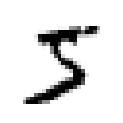

In [ ]:
plt.figure(figsize=(2,2))   # 2 X 2 inches, 1 inch ~ 80 pixels
plt.axis("off")
plt.imshow(x_train[0], cmap='Greys')

------------
The code below is to extract only a specific class of digits from the dataset, should you wish to work on a smaller scale.

In [ ]:
# collect specific digits

# train_filter = np.where((Y_train == 0 ) | (Y_train == 4))
# test_filter = np.where((Y_test == 0) | (Y_test == 4))

# X_train, Y_train = X_train[train_filter], Y_train[train_filter]
# X_test, Y_test = X_test[test_filter], Y_test[test_filter]

-----------

## <font color='orange'>**Dataset Distribution**<font/>

Let us now see how the data is distributed among all the classes.<br/><br/>
It is an important thing to check if the dataset is distributed evenly (with some margin allowed) among all classes, otherwise our model might be trained with a bias against a certain set of classes, and this might might work against it during testing or application.<br/><br/>
From the plotted histogram we see that the data is quite evenly distributed, so we can proceed further.

(array([5923., 6742., 5958., 6131., 5842., 5421., 5918., 6265., 5851.,
        5949.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

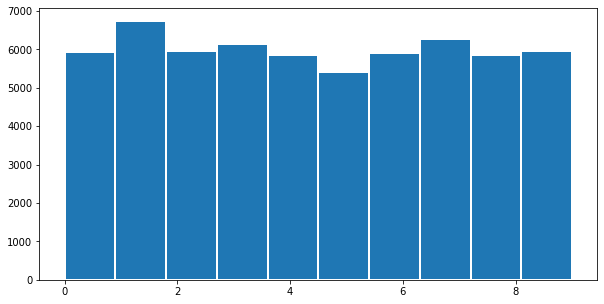

In [ ]:
# checking for even distribution

plt.figure(figsize=(10,5))
plt.hist(y_train, edgecolor='white', linewidth=2)

---------------

## <font color='orange'>**Categorical Labels vs. One-Hot Encoding**<font/>

The labels provided to us via the MNIST represent their respective digits i.e., a handwritten digit of 7 is labelled as '7' (categorical data). While this is conveninet for us, our nueral network will not see it that way.<br/><br/>

Although our dataset is that of digits, there really isn't any ordinal relationship among them, nor do we want there to be. The expectancy of our model should not be to classify the next digit image as + 1 of the previous image.<br/>

Using the provided labels will allow the model to assume a natural ordering between categories and may result in poor performance or unexpected results (predictions halfway between categories, or it assumes higher the categorical value, better the category.).<br/><br/>

To mitigate this problem, we use one-hot encoding (as shown below), where '0' indicates non-existant and '1' indicates existant.<br/><br/>

The list indices where '1' is encoded represent the respective digit i.e., for digit '5', the fifth index will be '1' and the rest will be '0'.

In [ ]:
# Raw labels

print(y_train[:10])

[5 0 4 1 9 2 1 3 1 4]


In [ ]:
# One-hot encoded labels (compare above)

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

print(y_train_cat[:10])

[[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


-----------------

## <font color='orange'>**Dataset Normalization**<font/>

Neural networks tend to work better with small values. A good way to judge this, is to check the range of your activation function in the last layer, or your output layer.<br/>
Large values might grow out of bounds and corrupt the network through subsquent training steps.<br/><br/>

Therefore, we normalize our image pixels values from [ 0, 255 ] to [ 0, 1 ].

In [ ]:
# normalization
x_train_reg = x_train.astype('float32') / 255.0
x_test_reg = x_test.astype('float32') / 255.0

--------------

## <font color='orange'>**Classifier Architecture**<font/>

We will first start with a relatively simple neural network. As mentioned, the network will comprise of fully connected, 1-D hidden layers. The ``Dense()`` layer provided by Keras will be useful here. Documentation for the same can be found [here](https://keras.io/api/layers/core_layers/dense/).<br/><br/>

We are now required to pass a 28 x 28 "square" data structure (MNIST image) to a vector (hidden layer). These are actually all tensors. More on that here: [ [1](https://www.tensorflow.org/guide/tensor) ], [ [2](https://en.wikipedia.org/wiki/Tensor) ].<br/><br/>

This incompatibility can be resolved by flattening the square image into a vector (1-D array), by using the ``Flatten()`` layer in Keras ([documentation](https://keras.io/api/layers/reshaping_layers/flatten/)). This layer simply multiplies the dimensions of an n-dimensional object to get the number of units in the vector. So here, 28*28 will give us 784.<br/><br/>

We are also initializing the weights of the neural network ``init = RandomNormal(stddev=0.02)`` to values randomly sampled from a standard normal distribution. This helps with convergence and performance of the network.<br/><br/>

The output layer will obviously contain 10 units sice we want our classifier to output probabilities for 10 classes of digits.<br/><br/>

A neural network has the tendency to memorize its training data, especially if it contains more than enough capacity. In such cases, the network fails catastrophically when subjected to the test data. This is the classic case of the network failing to generalize. To avoid this tendency, the model uses a regularizing layer or function. A common regularizing layer is ``Dropout()``.<br/><br/>

The idea of dropout is simple. Given a dropout rate (passed as an argument), the Dropout layer randomly removes that fraction of units from participating in the next layer. For example, if the first layer has 256 units, after dropout = 0.45 is applied, only (1 - 0.45) * 256 units = 140 units from layer 1 participate in layer 2.<br/><br/>

The Dropout layer makes neural networks robust to unforeseen input data because
the network is trained to predict correctly, even if some units are missing. It's worth
noting that dropout is not used in the output layer and it is only active during
training. Moreover, dropout is not present during predictions.<br/><br/>

The optimizer "sgd" used here is Stochastic Gradient Descent. In SGD, a mini batch of samples is chosen to compute an approximate value of the descent.<br/>

**NOTE:** Since optimization is based on differentiation, it follows that an important criterion of the loss function must be for it to be smooth or differentiable. This is an important constraint to keep in mind when introducing a new loss function.<br/><br/>

How far the predicted tensor is from the one-hot ground truth vector is called loss. One type of loss function is mean_squared_error (MSE), or the average of the squares of the differences between the target or label and the prediction .<br/>
 In the current example, we are using **categorical_crossentropy**. It's the negative of the sum of the product of the target or label and the logarithm of the prediction per category.

In [ ]:
def define_classifier(image_shape):

  init = RandomNormal(stddev=0.02)
  in_image = Input(shape=image_shape)

  c = Flatten()(in_image)

  c = Dense(16, activation='relu', kernel_initializer=init)(c)
  c = Dropout(0.1)(c)

  c = Dense(32, activation='relu', kernel_initializer=init)(c)
  c = Dropout(0.1)(c)

  c = Dense(64, activation='relu', kernel_initializer=init)(c)
  c = Dropout(0.1)(c)

  out = Dense(10, activation = 'softmax', kernel_initializer=init)(c)

  model = Model(in_image, out)
  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    
  return model

--------------

We finally create the model object by calling the ``define_classifier()`` function, and print out its structure.<br/><br/>

Please note the **output shape** of each layer and the **number of parameters**.

The "None" shown as the first dimension of each output shape tell us that the network is maleable to that dimension and we can pass any value in it. For example in ``[(None, 28, 28, 1)]`` the ``(28, 28, 1)`` represents the image shape and ``None`` here means we can pass any number images at a time. But they have to be reshaped properly (in a tensor).

In [ ]:
model = define_classifier((28,28,1))
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                12560     
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                2112  

---------------

## <font color='orange'>**Training the model**<font/>

We use the model object to call ``fit()`` and pass our normalized training images ``x_train_reg`` and corresponding one-hot encoded labels ``y_train_cat`` as arguments.

We train it for 10 **epochs** for now. One Epoch is when an **entire** dataset is passed forward and backward through the neural network only **once**.<br/>
Since one epoch is too big to feed to the computer at once we divide it in several smaller batches.<br/><br/>

Hence, we pass our dataset in batches of 64, shown by ``batch_size``.

In [ ]:
model.fit(x_train_reg, y_train_cat, epochs=10, batch_size=64)

Epoch 1/10
938/938 [==============================] - 2s 1ms/step - loss: 2.3021 - accuracy: 0.1130
Epoch 2/10
938/938 [==============================] - 1s 2ms/step - loss: 2.3013 - accuracy: 0.1122
Epoch 3/10
938/938 [==============================] - 1s 1ms/step - loss: 2.3013 - accuracy: 0.1103
Epoch 4/10
938/938 [==============================] - 1s 1ms/step - loss: 2.3012 - accuracy: 0.1108
Epoch 5/10
938/938 [==============================] - 1s 2ms/step - loss: 2.3011 - accuracy: 0.1123
Epoch 6/10
938/938 [==============================] - 1s 1ms/step - loss: 2.3005 - accuracy: 0.1152
Epoch 7/10
938/938 [==============================] - 1s 1ms/step - loss: 2.3014 - accuracy: 0.1110
Epoch 8/10
938/938 [==============================] - 1s 1ms/step - loss: 2.3009 - accuracy: 0.1126
Epoch 9/10
938/938 [==============================] - 1s 1ms/step - loss: 2.3011 - accuracy: 0.1112
Epoch 10/10
938/938 [==============================] - 1s 1ms/step - loss: 2.3007 - accuracy: 0.1116

----------------

## <font color='orange'>**Welcome to Practical Deep Learning. It's hell, and you're gonna love it.**<font/>

Checking the **training** accuracy above, we see that it is **11%**. :(<br/><br>

Perhaps our network is not "deep" enough i.e., there aren't enough parameters to tune such that our process of classification might be encoded. Let us increase its "depth".<br/><br/>

Since, our training accuracy is so bad, we won't be testing/evaluating it just yet. Still, for a perspective, the code below calls on the model to predict one single image.<br/>

As you see, the image is that of digit '9' but it is classified as '5'.

In [ ]:
# input1 = np.reshape(x_test_reg[7],(1,28,28,1))
# out = model.predict(input1)
# plt.imshow(x_test_reg[7], cmap='Greys')
# print(np.argmin(out))

----------

## <font color='orange'>**Mk. 2**<font/>

We have added two additional layers of 128 and 256 units each, and increased the corresponding dropout rate, given the increased number of units in the layer.<br/><br/>

Let us see how this changes things.

Note the increased number of parameters in the model summary.

----------

In [ ]:
def define_classifier(image_shape):

  init = RandomNormal(stddev=0.02)
  in_image = Input(shape=image_shape)

  c = Flatten()(in_image)

  c = Dense(32, activation='relu', kernel_initializer=init)(c)
  c = Dropout(0.1)(c)

  c = Dense(64, activation='relu', kernel_initializer=init)(c)
  c = Dropout(0.1)(c)

  c = Dense(128, activation='relu', kernel_initializer=init)(c)
  c = Dropout(0.2)(c)

  c = Dense(256, activation='relu', kernel_initializer=init)(c)
  c = Dropout(0.3)(c)

  out = Dense(10, activation = 'softmax', kernel_initializer=init)(c)

  model = Model(in_image, out)
  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    
  return model

In [ ]:
model = define_classifier((28,28,1))
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 32)                25120     
_________________________________________________________________
dropout_3 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
_________________________________________________________________
dropout_4 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               8320

In [ ]:
model.fit(x_train_reg, y_train_cat, epochs=10, batch_size=64)

Epoch 1/10
938/938 [==============================] - 3s 3ms/step - loss: 2.3021 - accuracy: 0.1129
Epoch 2/10
938/938 [==============================] - 2s 3ms/step - loss: 2.3013 - accuracy: 0.1115
Epoch 3/10
938/938 [==============================] - 2s 2ms/step - loss: 2.3013 - accuracy: 0.1110
Epoch 4/10
938/938 [==============================] - 2s 3ms/step - loss: 2.3012 - accuracy: 0.1126
Epoch 5/10
938/938 [==============================] - 2s 3ms/step - loss: 2.3010 - accuracy: 0.1109
Epoch 6/10
938/938 [==============================] - 2s 2ms/step - loss: 2.3011 - accuracy: 0.1128
Epoch 7/10
938/938 [==============================] - 2s 2ms/step - loss: 2.3012 - accuracy: 0.1127
Epoch 8/10
938/938 [==============================] - 2s 2ms/step - loss: 2.3016 - accuracy: 0.1101
Epoch 9/10
938/938 [==============================] - 2s 3ms/step - loss: 2.3010 - accuracy: 0.1126
Epoch 10/10
938/938 [==============================] - 2s 2ms/step - loss: 2.3009 - accuracy: 0.1124

---------------

## <font color='orange'>**Mk. 3**<font/>

Okay, still bad.<br/><br/>

Maybe the model isn't getting enough chances to properly tune itself according to our needs i.e., maybe the model isn't being trained enough.<br/><br/>

Let us increase the number of epochs to 20 and see what happens.

In [ ]:
# didn't rebuild the model

model.fit(x_train_reg, y_train_cat, epochs=20, batch_size=64)

Epoch 1/20
938/938 [==============================] - 2s 3ms/step - loss: 2.3009 - accuracy: 0.1124
Epoch 2/20
938/938 [==============================] - 2s 3ms/step - loss: 2.3008 - accuracy: 0.1124
Epoch 3/20
938/938 [==============================] - 2s 3ms/step - loss: 2.3007 - accuracy: 0.1124
Epoch 4/20
938/938 [==============================] - 2s 2ms/step - loss: 2.3005 - accuracy: 0.1124
Epoch 5/20
938/938 [==============================] - 2s 3ms/step - loss: 2.3003 - accuracy: 0.1124
Epoch 6/20
938/938 [==============================] - 2s 2ms/step - loss: 2.2998 - accuracy: 0.1124
Epoch 7/20
938/938 [==============================] - 2s 2ms/step - loss: 2.2987 - accuracy: 0.1124
Epoch 8/20
938/938 [==============================] - 2s 3ms/step - loss: 2.2956 - accuracy: 0.1124
Epoch 9/20
938/938 [==============================] - 2s 3ms/step - loss: 2.2771 - accuracy: 0.1459
Epoch 10/20
938/938 [==============================] - 2s 2ms/step - loss: 2.0104 - accuracy: 0.2236

--------

## <font color='orange'>**Mk. 4**<font/>

Alright! Major improvement. A jump from 11% to **86%** accuracy isn't bad.<br/><br/>

A keen observer might note here that the accuracy starts improving from the 8th epoch, whereas according to our previous run of the model it should at least remain the same till 10th epoch, since we haven't made any changes to the model architecture.<br/><br/>

The reason is that we didn't call ``define_classifier()`` and **rebuild** our model. We called the fit function on the previously trained model itself. This allowed our model to use the knowledge gained from its previous run.<br/>
This is just something to note, you don't **have** to do this.

-----------

Okay, let's try to improve the accuracy even further. Maybe the depth is still an issue.<br/>
 We add another layer of 256 units.

In [ ]:
def define_classifier(image_shape):

  init = RandomNormal(stddev=0.02)
  in_image = Input(shape=image_shape)

  c = Flatten()(in_image)

  c = Dense(32, activation='relu', kernel_initializer=init)(c)
  c = Dropout(0.1)(c)

  c = Dense(64, activation='relu', kernel_initializer=init)(c)
  c = Dropout(0.1)(c)

  c = Dense(128, activation='relu', kernel_initializer=init)(c)
  c = Dropout(0.2)(c)

  c = Dense(256, activation='relu', kernel_initializer=init)(c)
  c = Dropout(0.3)(c)

  c = Dense(256, activation='relu', kernel_initializer=init)(c)
  c = Dropout(0.4)(c)

  out = Dense(10, activation = 'softmax', kernel_initializer=init)(c)

  model = Model(in_image, out)
  model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    
  return model

In [ ]:
model = define_classifier((28,28,1))
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 32)                25120     
_________________________________________________________________
dropout_7 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_10 (Dense)             (None, 64)                2112      
_________________________________________________________________
dropout_8 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               8320

In [ ]:
model.fit(x_train_reg, y_train_cat, epochs=20, batch_size=64)

Epoch 1/20
938/938 [==============================] - 4s 4ms/step - loss: 2.3022 - accuracy: 0.1092
Epoch 2/20
938/938 [==============================] - 4s 4ms/step - loss: 2.3013 - accuracy: 0.1115
Epoch 3/20
938/938 [==============================] - 4s 4ms/step - loss: 2.3012 - accuracy: 0.1137
Epoch 4/20
938/938 [==============================] - 4s 4ms/step - loss: 2.3010 - accuracy: 0.1136
Epoch 5/20
938/938 [==============================] - 4s 5ms/step - loss: 2.3013 - accuracy: 0.1116
Epoch 6/20
938/938 [==============================] - 4s 5ms/step - loss: 2.3012 - accuracy: 0.1114
Epoch 7/20
938/938 [==============================] - 4s 4ms/step - loss: 2.3014 - accuracy: 0.1117
Epoch 8/20
938/938 [==============================] - 4s 4ms/step - loss: 2.3011 - accuracy: 0.1124
Epoch 9/20
938/938 [==============================] - 4s 4ms/step - loss: 2.3010 - accuracy: 0.1119
Epoch 10/20
938/938 [==============================] - 4s 4ms/step - loss: 2.3013 - accuracy: 0.1096

------------

## <font color='orange'>**Mk. 5**<font/>

Bad choice. Our accuracy has dropped again.<br/><br/>

We can't really say what the reason is here. Because as per our previous experience, increasing the model capacity shouldn't harm the model in this way.<br/>

 Maybe we made the model overly complex and it **failed to converge**? We need to investigate this behaviour. Re-build the model and train it multiple times to check if the optimizer isn't the problem<br/><br/>

 Let's keep the architecture as it is, and change the optimizer from SGD to Adam (adaptive Moments). More on it [here](https://arxiv.org/abs/1412.6980).

In [ ]:
def define_classifier(image_shape):

  init = RandomNormal(stddev=0.02)
  in_image = Input(shape=image_shape)

  c = Flatten()(in_image)

  c = Dense(32, activation='relu', kernel_initializer=init)(c)
  c = Dropout(0.1)(c)

  c = Dense(64, activation='relu', kernel_initializer=init)(c)
  c = Dropout(0.1)(c)

  c = Dense(128, activation='relu', kernel_initializer=init)(c)
  c = Dropout(0.2)(c)

  c = Dense(256, activation='relu', kernel_initializer=init)(c)
  c = Dropout(0.3)(c)

  c = Dense(256, activation='relu', kernel_initializer=init)(c)
  c = Dropout(0.4)(c)

  out = Dense(10, activation = 'softmax', kernel_initializer=init)(c)

  model = Model(in_image, out)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
  return model

In [ ]:
model = define_classifier((28,28,1))

In [ ]:
model.fit(x_train_reg, y_train_cat, epochs=20, batch_size=64)

Epoch 1/20
938/938 [==============================] - 5s 5ms/step - loss: 1.4602 - accuracy: 0.4229
Epoch 2/20
938/938 [==============================] - 5s 5ms/step - loss: 0.4210 - accuracy: 0.8878
Epoch 3/20
938/938 [==============================] - 5s 5ms/step - loss: 0.3053 - accuracy: 0.9213
Epoch 4/20
938/938 [==============================] - 4s 5ms/step - loss: 0.2523 - accuracy: 0.9326
Epoch 5/20
938/938 [==============================] - 5s 5ms/step - loss: 0.2288 - accuracy: 0.9371
Epoch 6/20
938/938 [==============================] - 4s 5ms/step - loss: 0.2096 - accuracy: 0.9431
Epoch 7/20
938/938 [==============================] - 5s 5ms/step - loss: 0.2004 - accuracy: 0.9449
Epoch 8/20
938/938 [==============================] - 5s 5ms/step - loss: 0.1904 - accuracy: 0.9485
Epoch 9/20
938/938 [==============================] - 5s 5ms/step - loss: 0.1855 - accuracy: 0.9491
Epoch 10/20
938/938 [==============================] - 5s 5ms/step - loss: 0.1678 - accuracy: 0.9534

--------------

Okay! The accuracy has increased in a major way, and right from the 2nd epoch.<br/>
You might want to take some time here (not during the lecture :D) to think on why the change to Adam optimizer affected the model this much. Please keep in mind our previous attempts too.<br/><br/>

Alright, with **96%** training accuracy, our model is good enough to test. We need to see if it has **overfitted** on our training data or not.

----------

``model.evaluate`` here does the testing for us. We need to pass our test images ``x_test_reg`` and corresponding labels ``y_test_cat`` as arguments. It will return a list with loss and accuracy values.

In [ ]:
score = model.evaluate(x_test_reg, y_test_cat, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.13050980865955353
Test accuracy: 0.9646999835968018


-----------

Testing accuracy is the same as training accuracy, **96%**. Nice!

-------------

## <font color='orange'>**Mk. 6**<font/>

We haven't checked what chaning the ``batch_size`` does to our model. Let's try that and increase the size to 128.<br/>
The batch size is recommended to be a power of 2 for GPU
optimization purposes.

In [ ]:
model = define_classifier((28,28,1))
model.fit(x_train_reg, y_train_cat, epochs=20, batch_size=128)

Epoch 1/20
469/469 [==============================] - 4s 7ms/step - loss: 1.4961 - accuracy: 0.4284
Epoch 2/20
469/469 [==============================] - 3s 7ms/step - loss: 0.4284 - accuracy: 0.8757
Epoch 3/20
469/469 [==============================] - 3s 7ms/step - loss: 0.3168 - accuracy: 0.9124
Epoch 4/20
469/469 [==============================] - 3s 7ms/step - loss: 0.2683 - accuracy: 0.9248
Epoch 5/20
469/469 [==============================] - 3s 7ms/step - loss: 0.2413 - accuracy: 0.9318
Epoch 6/20
469/469 [==============================] - 3s 7ms/step - loss: 0.2289 - accuracy: 0.9365
Epoch 7/20
469/469 [==============================] - 3s 7ms/step - loss: 0.2057 - accuracy: 0.9421
Epoch 8/20
469/469 [==============================] - 3s 7ms/step - loss: 0.1991 - accuracy: 0.9447
Epoch 9/20
469/469 [==============================] - 3s 7ms/step - loss: 0.1951 - accuracy: 0.9470
Epoch 10/20
469/469 [==============================] - 3s 7ms/step - loss: 0.1740 - accuracy: 0.9513

------------

## <font color='orange'>**Mk. 7**<font/>

Okay, not that much change. It's actually starting to decrease the accuracy.<br/>
More on that [here](https://stats.stackexchange.com/questions/164876/what-is-the-trade-off-between-batch-size-and-number-of-iterations-to-train-a-neu).<br/><br/>

Let us increase the depth of our model even further. Since our optimizer choice was so good, we are hoping it can handle a model of increased depth.<br/>

We add another layer of 512 units.

In [ ]:
def define_classifier(image_shape):

  init = RandomNormal(stddev=0.02)
  in_image = Input(shape=image_shape)

  c = Flatten()(in_image)

  c = Dense(64, activation='relu', kernel_initializer=init)(c)
  c = Dropout(0.1)(c)

  c = Dense(128, activation='relu', kernel_initializer=init)(c)
  c = Dropout(0.1)(c)

  c = Dense(256, activation='relu', kernel_initializer=init)(c)
  c = Dropout(0.3)(c)

  c = Dense(256, activation='relu', kernel_initializer=init)(c)
  c = Dropout(0.3)(c)

  c = Dense(512, activation='relu', kernel_initializer=init)(c)
  c = Dropout(0.4)(c)

  out = Dense(10, activation = 'softmax', kernel_initializer=init)(c)

  model = Model(in_image, out)
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
  return model

In [ ]:
model = define_classifier((28,28,1))
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_27 (Dense)             (None, 64)                50240     
_________________________________________________________________
dropout_22 (Dropout)         (None, 64)                0         
_________________________________________________________________
dense_28 (Dense)             (None, 128)               8320      
_________________________________________________________________
dropout_23 (Dropout)         (None, 128)               0         
_________________________________________________________________
dense_29 (Dense)             (None, 256)               3302

In [ ]:
# bigger not always better. > train time. try to increase compactness

model.fit(x_train_reg, y_train_cat, epochs=20, batch_size=64)

Epoch 1/20
938/938 [==============================] - 8s 8ms/step - loss: 1.0060 - accuracy: 0.6305
Epoch 2/20
938/938 [==============================] - 8s 8ms/step - loss: 0.2220 - accuracy: 0.9385
Epoch 3/20
938/938 [==============================] - 7s 8ms/step - loss: 0.1726 - accuracy: 0.9524
Epoch 4/20
938/938 [==============================] - 7s 8ms/step - loss: 0.1465 - accuracy: 0.9602
Epoch 5/20
938/938 [==============================] - 7s 8ms/step - loss: 0.1260 - accuracy: 0.9648
Epoch 6/20
938/938 [==============================] - 8s 8ms/step - loss: 0.1189 - accuracy: 0.9666
Epoch 7/20
938/938 [==============================] - 8s 8ms/step - loss: 0.1105 - accuracy: 0.9696
Epoch 8/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0962 - accuracy: 0.9726
Epoch 9/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0942 - accuracy: 0.9736
Epoch 10/20
938/938 [==============================] - 8s 8ms/step - loss: 0.0883 - accuracy: 0.9757

---------

Okay, we have pushed it beyond **98%**.<br/>
You might be starting to notice the increased training time now.

In [ ]:
score = model.evaluate(x_test_reg, y_test_cat, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.09701474756002426
Test accuracy: 0.9768999814987183


-----------

## <font color='orange'>**Points to Note**<font/>

Test accuracy has decreased a bit but our model is good enough.<br/>
Please note, that a deeper model might not always be the best idea. It depends on the scenario really.<br/><br/>
For a nominal percentage increase in accuracy in an image model, building a model that takes twice as long to train is not a good trade-off.<br/>
This small percentage will have no consequence in production in case of image classification or recognition models.<br/>
However, a small percentage increase in an ML model used in the financial sector, may equal to millions in revenue.<br/><br/>
Evaluate your data and scenario and choose your architecture wisely.

-------------

## <font color='orange'>**Blind Run**<font/>

Let us now train the same model on a completely new dataset and see how it performs.<br/>
**We are not going to fine-tune our model here. This is just to see how it holds up against images with increased complexity.**

------------

# <font color='orange'>**Fashion MNIST Dataset**<font/>

This is a dataset of 60,000 28x28 grayscale images of 10 fashion categories, along with a test set of 10,000 images.

(Label, 	Description)<br/>
(0, 	T-shirt/top)
(1, 	Trouser)
(2, 	Pullover)
(3, 	Dress)
(4, 	Coat)
(5, 	Sandal)
(6, 	Shirt)
(7, 	Sneaker)
(8, 	Bag)
(9, 	Ankle boot)

In [ ]:
from tensorflow.keras.datasets import fashion_mnist

In [ ]:
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
print(x_train.shape, x_test.shape)

4423680/4422102 [==============================] - 0s 0us/step
(60000, 28, 28) (10000, 28, 28)


9


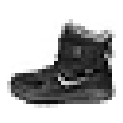

In [ ]:
plt.figure(figsize=(2,2))   # 2 X 2 inches, 1 inch ~ 80 pixels
plt.axis("off")
plt.imshow(x_train[0], cmap='Greys')
print(y_train[0])

--------------

As you can see from the sample image above, it is noticeably more complex than an image of a handwritten digit.

-----------

(array([6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000., 6000.,
        6000.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

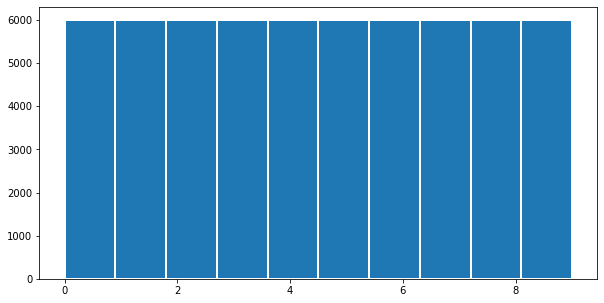

In [ ]:
# check even distribution

plt.figure(figsize=(10,5))
plt.hist(y_train, edgecolor='white', linewidth=2)

In [ ]:
# one-hot encoding and normalization

y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)
x_train_reg = x_train.astype('float32') / 255.0
x_test_reg = x_test.astype('float32') / 255.0

In [ ]:
model = define_classifier((28,28,1))
model.fit(x_train_reg, y_train_cat, epochs=20, batch_size=64)

Epoch 1/20
938/938 [==============================] - 8s 8ms/step - loss: 1.1698 - accuracy: 0.5196
Epoch 2/20
938/938 [==============================] - 7s 8ms/step - loss: 0.5601 - accuracy: 0.7916
Epoch 3/20
938/938 [==============================] - 8s 8ms/step - loss: 0.4760 - accuracy: 0.8272
Epoch 4/20
938/938 [==============================] - 7s 8ms/step - loss: 0.4323 - accuracy: 0.8467
Epoch 5/20
938/938 [==============================] - 8s 8ms/step - loss: 0.4007 - accuracy: 0.8569
Epoch 6/20
938/938 [==============================] - 8s 8ms/step - loss: 0.3849 - accuracy: 0.8658
Epoch 7/20
938/938 [==============================] - 8s 8ms/step - loss: 0.3648 - accuracy: 0.8691
Epoch 8/20
938/938 [==============================] - 8s 8ms/step - loss: 0.3557 - accuracy: 0.8757
Epoch 9/20
938/938 [==============================] - 8s 9ms/step - loss: 0.3438 - accuracy: 0.8772
Epoch 10/20
938/938 [==============================] - 7s 8ms/step - loss: 0.3392 - accuracy: 0.8773

In [ ]:
score = model.evaluate(x_test_reg, y_test_cat, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.3620312213897705
Test accuracy: 0.8780999779701233


-------------

## <font color='orange'>**Final Notes**<font/>

As your dataset complexity changes, you will need to fine-tune your model accordingly. You might end following our procedure earlier, or might discover a better one.<br/>
The purpose here was to give an example of how to react to failures when confronting a practical deep learning problem.<br/><br/>

*“Breathe as the tears flow,<br/>
Breathe when you cannot gaze up high,<br/>
Breathe as to know the world will lie,<br/>
Breathe when you choke to ask: “Why?”<br/>
Breathe even when you are about to die.*"<br/><br/>
-Somya Kedia